In [124]:
# Try for one file first
import librosa
import os
import soundfile as sf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as ms
from tqdm import tqdm
import pickle
import random
import math
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns

import IPython.display
import librosa.display
import time
import joblib
from joblib import Parallel, delayed
ms.use('seaborn-muted')
%matplotlib inline

In [44]:
emotion_dict = {'ang': 0,
                'hap': 1,
                'exc': 2,
                'sad': 3,
                'fru': 4,
                'fea': 5,
                'sur': 6,
                'neu': 7,
                'xxx': 8,
                'oth': 8,
                'dis': 8}

In [46]:
emotion_full = {'ang': 'angry',
                'hap': 'happiness',
                'exc': 'excited',
                'sad': 'sadness',
                'fru': 'frustrated',
                'fea': 'fear',
                'sur': 'surprised',
                'neu': 'neutral',
                'xxx': 'others',
                'oth': 'others',
                'dis': 'others'}

In [559]:
labels_df = pd.read_csv('/home/user/shaheen.perveen/SER_new/preprocess_info/df_iemocap.csv')
iemocap_dir = '/data/shaheen.perveen/IEMOCAP_full_release/'
save_dir = '/home/user/shaheen.perveen/SER_new/preprocess_info/'
audio_vectors_path= save_dir + 'audio_vectors_'
model_save_path = '/home/user/shaheen.perveen/SER_new/saved_models'

In [4]:
def features(X, sample_rate=22050):

    
    stft = np.abs(librosa.stft(X))
    
    pitches, magnitudes = librosa.piptrack(X, sr=sample_rate, S=stft, fmin=70, fmax=400)
    pitch = []
    for i in range(magnitudes.shape[1]):
        index = magnitudes[:, 1].argmax()
        pitch.append(pitches[index, i])
        
    pitch_tuning_offset = librosa.pitch_tuning(pitches)
    pitchmean = np.mean(pitch)
    pitchstd = np.std(pitch)
    pitchmax = np.max(pitch)
    pitchmin = np.min(pitch)
    
    cent = librosa.feature.spectral_centroid(y=X, sr=sample_rate)
    cent = cent / np.sum(cent)
    meancent = np.mean(cent)
    stdcent = np.std(cent)
    maxcent = np.max(cent)
    
    flatness = np.mean(librosa.feature.spectral_flatness(y=X))

    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=12).T, axis=0)
    mfccsstd = np.std(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=12).T, axis=0)
    mfccmax = np.max(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=12).T, axis=0)
    chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)

    mel = np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T, axis=0)
    contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T, axis=0)
    zerocr = np.mean(librosa.feature.zero_crossing_rate(X))

    rms = librosa.feature.rms(X + 0.0001)[0]
    meanrms = np.mean(rms)
    stdrms = np.std(rms)
    maxrms = np.max(rms)
    
    y_harmonic = np.mean(librosa.effects.hpss(X)[0])
    sig_mean = np.mean(abs(X))
    sig_std = np.std(X)

    ext_features = np.array([
        flatness, zerocr, meancent, stdcent,
        maxcent, pitchmean, pitchmax, pitchmin, pitchstd,
        pitch_tuning_offset, meanrms, maxrms, stdrms, y_harmonic, sig_mean, sig_std])

    
    ext_features = np.concatenate((ext_features, mfccs, mfccsstd, mfccmax, chroma, mel, contrast))
    return ext_features
    

In [92]:
vectorized_feature = np.vectorize(features)

In [65]:
sr = 22050

In [5]:
labels_df = pd.read_csv('/home/user/shaheen.perveen/SER_new/preprocess_info/df_iemocap.csv')
iemocap_dir = '/home/user/shaheen.perveen/SER_new/IEMOCAP_full_release/'
save_dir = '/home/user/shaheen.perveen/SER_new/preprocess_info/'
audio_vectors_path= save_dir + 'audio_vectors_'

In [7]:
labels_df = pd.read_csv('/home/user/shaheen.perveen/SER_new/preprocess_info/df_iemocap.csv')

In [8]:
labels_df_subset = labels_df[labels_df["emotion"].isin(["neu", 'ang', 'hap', 'sad'])]

In [9]:
labels_df_subset.emotion.value_counts()

neu    1708
ang    1103
sad    1084
hap     595
Name: emotion, dtype: int64

In [10]:
labels_df_subset = labels_df_subset[["wav_file", "emotion"]]

In [11]:
labels_df_subset = labels_df_subset.rename(columns={"wav_file": "filename"})

In [12]:
labels_df_subset.head()

,filename,emotion
29,Ses01F_impro07_M012,neu
30,Ses01F_impro07_M013,neu
35,Ses01F_impro07_M018,neu
36,Ses01F_impro07_M019,hap
37,Ses01F_impro03_F000,hap


In [13]:
pickle_to_df = pd.DataFrame(columns=["filename", "audio_vector"])

In [14]:
for sess in range(1, 6):
    audio_vectors = pickle.load(open('{}{}.pkl'.format(audio_vectors_path, sess), 'rb'))
    for index, row in tqdm(labels_df[labels_df['wav_file'].str.contains('Ses0{}'.format(sess))].iterrows()):

        wav_file_name = row['wav_file']
        y = audio_vectors[wav_file_name]
        list_y = list(y)
        pickle_to_df = pickle_to_df.append({'filename': wav_file_name, 'audio_vector': list_y}, ignore_index=True)

1819it [00:12, 143.85it/s]
1811it [00:12, 149.78it/s]
2136it [00:15, 141.72it/s]
2103it [00:13, 152.46it/s]
2170it [00:14, 148.29it/s]


In [15]:
pickle_to_subset = labels_df_subset.merge(pickle_to_df, on="filename")

In [16]:
print(pickle_to_subset.shape)
print(pickle_to_df.shape)
print(labels_df_subset.shape)

(4490, 3)
(10039, 2)
(4490, 2)


In [17]:
pickle_to_subset.head()

,filename,emotion,audio_vector
0,Ses01F_impro07_M012,neu,"[-0.001751249, -0.0022995116, -0.0022942421, -..."
1,Ses01F_impro07_M013,neu,"[0.0003422114, 0.0027063466, 0.0076859626, 0.0..."
2,Ses01F_impro07_M018,neu,"[0.032214236, 0.035951234, 0.03672457, 0.03514..."
3,Ses01F_impro07_M019,hap,"[-0.08024377, -0.078011915, -0.084221944, -0.1..."
4,Ses01F_impro03_F000,hap,"[-0.002304704, -0.0011479069, -0.001996223, -0..."


In [19]:
pickle_to_subset = pickle_to_subset[["filename", "audio_vector", "emotion"]]

In [26]:
train, test = train_test_split(pickle_to_subset, test_size=0.2, stratify=pickle_to_subset['emotion']) 

In [27]:
train.head()

,filename,audio_vector,emotion
71,Ses01M_script03_1_M022,"[0.00083886227, 0.002202196, 0.0013805811, -0....",hap
2789,Ses04M_impro05_M011,"[0.0009097477, 0.0009766775, 0.00076252216, 0....",ang
2298,Ses03F_script01_3_M035,"[-0.0007819065, -0.0012510878, -0.0018399801, ...",sad
4365,Ses05M_script01_1_M033,"[-0.0013128931, -0.0014019415, -0.0014923624, ...",ang
555,Ses01M_script01_3_M029,"[0.0026844796, 0.002342638, 0.0021269638, 0.00...",sad


In [181]:
import joblib
from joblib import Parallel, delayed
from PIL import Image
import multiprocessing as mp

In [28]:

def feature_split_extract(y):
    try:
        print("inside function")
        y = np.array(y)
        y_split = np.array_split(y, 5)
        split_features = np.array(list(map(features, y_split)))
        return split_features
    except:
        print("some error occurred")
        
features_parallel_train = []
emotion_parallel_train = []

for row in train.itertuples(index=True, name='Pandas'):
    y = getattr(row, "audio_vector")
    emotion = getattr(row, "emotion")
    split_features = feature_split_extract(y)
    features_parallel_train.append(split_features)
    emotion_parallel_train.append(emotion)

features_parallel_train = np.array(features_parallel_train)
emotion_parallel_train = np.array(emotion_parallel_train)
    

inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside f

inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside f

inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside f

/opt/anaconda/anaconda3/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')


inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside f

inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside f

inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside f

inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside f

inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function


In [29]:

def feature_split_extract(y):
    try:
        print("inside function")
        y = np.array(y)
        y_split = np.array_split(y, 5)
        split_features = np.array(list(map(features, y_split)))
        return split_features
    except:
        print("some error occurred")
        
features_parallel_test = []
emotion_parallel_test = []

for row in test.itertuples(index=True, name='Pandas'):
    y = getattr(row, "audio_vector")
    emotion = getattr(row, "emotion")
    split_features = feature_split_extract(y)
    features_parallel_test.append(split_features)
    emotion_parallel_test.append(emotion)

features_parallel_test = np.array(features_parallel_test)
emotion_parallel_test = np.array(emotion_parallel_test)
    

inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside f

/opt/anaconda/anaconda3/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')


inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside f

inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside f

In [33]:
features_parallel_test.shape
emotion_parallel_test.shape

(898,)

In [44]:
element_label_test = np.vectorize(emotion_dict.get)(emotion_parallel_test)
element_label_train = np.vectorize(emotion_dict.get)(emotion_parallel_train)

In [236]:
# sr = 22050
# start = time.time()

# def feature_split_extract(y, label):
# #     try:
#     print("inside function")
# #     y = np.array(y)
# #     y_split = np.array_split(y, 5)
# #     print(y_split)
# #     split_features = np.array(list(map(features, y_split)))
# #     print(type(split_features))
# #     features_parallel_test.append(split_features)
#     features_parallel_test.append(y)
# #     emotion_parallel_test.append(label)
# #     except:
# #         print("some error occurred")
        
        
    
# pool = mp.Pool(mp.cpu_count())
# pool_starmap = pool.starmap_async(feature_split_extract,[(getattr(row, "audio_vector"), getattr(row, "emotion")) for row in pickle_to_sample.itertuples(index=True, name='Pandas')])
# pool_starmap.wait()
# pool.close()
# end = time.time()
# print(end-start)


inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function
inside function


KeyboardInterrupt


inside function


Process ForkPoolWorker-374:
Process ForkPoolWorker-370:
Process ForkPoolWorker-380:
Process ForkPoolWorker-373:
Process ForkPoolWorker-385:
Process ForkPoolWorker-389:
Process ForkPoolWorker-387:
Process ForkPoolWorker-388:
Process ForkPoolWorker-383:
Process ForkPoolWorker-386:
Process ForkPoolWorker-384:
Process ForkPoolWorker-372:
Process ForkPoolWorker-382:
Process ForkPoolWorker-369:
Process ForkPoolWorker-390:
Process ForkPoolWorker-381:
Traceback (most recent call last):
Process ForkPoolWorker-378:
Process ForkPoolWorker-377:
Process ForkPoolWorker-379:
Process ForkPoolWorker-376:
Process ForkPoolWorker-371:
Process ForkPoolWorker-375:
Process ForkPoolWorker-391:
Process ForkPoolWorker-392:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (mo

  File "/opt/anaconda/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/anaconda/anaconda3/lib/python3.6/multiprocessing/queues.py", line 334, in get
    with self._rlock:
  File "/opt/anaconda/anaconda3/lib/python3.6/multiprocessing/queues.py", line 334, in get
    with self._rlock:
  File "/opt/anaconda/anaconda3/lib/python3.6/multiprocessing/queues.py", line 334, in get
    with self._rlock:
  File "/opt/anaconda/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/anaconda/anaconda3/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/opt/anaconda/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/anaconda/anaconda3/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/opt/anaconda/anaconda3/

KeyboardInterrupt: 

  File "/opt/anaconda/anaconda3/lib/python3.6/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/opt/anaconda/anaconda3/lib/python3.6/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/opt/anaconda/anaconda3/lib/python3.6/multiprocessing/queues.py", line 334, in get
    with self._rlock:
  File "/opt/anaconda/anaconda3/lib/python3.6/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/opt/anaconda/anaconda3/lib/python3.6/multiprocessing/queues.py", line 334, in get
    with self._rlock:
  File "/opt/anaconda/anaconda3/lib/python3.6/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/opt/anaconda/anaconda3/lib/python3.6/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/opt/anaconda/anaconda3/lib/python3.6/multiprocessing/synchronize.py", line 

PyTorch Modeling

In [34]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import TensorDataset, DataLoader

In [394]:
features_train_tensor = torch.stack([torch.Tensor(i) for i in features_parallel_train])
emotion_train_tensor = torch.from_numpy(element_label_train)
train_ds = TensorDataset(features_train_tensor, emotion_train_tensor)
trainloader = DataLoader(train_ds, batch_size=256, shuffle=True)

In [395]:
print(len(trainloader.dataset))

3592


In [396]:
trainiter = iter(trainloader)
features, labels = next(trainiter)
features.shape, labels.shape

(torch.Size([256, 5, 199]), torch.Size([256]))

In [397]:
features_test_tensor = torch.stack([torch.Tensor(i) for i in features_parallel_test])
emotion_test_tensor = torch.from_numpy(element_label_test)
test_ds = TensorDataset(features_test_tensor, emotion_test_tensor)
testloader = DataLoader(test_ds, batch_size=256)

In [398]:
testiter = iter(testloader)
features, labels = next(trainiter)
features.shape, labels.shape

(torch.Size([256, 5, 199]), torch.Size([256]))

In [400]:
class LSTMClassifier(nn.Module):

    def __init__(self, embedding_dim, hidden_dim, num_layers, output_size):
        super(LSTMClassifier, self).__init__()
        self.hidden_dim = hidden_dim

        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers, batch_first=True)

        # The linear layer that maps from hidden state space to tag space
        self.hidden2out = nn.Linear(hidden_dim, output_size)

    def forward(self, input_seq):
        lstm_out, (hidden, ct) = self.lstm(input_seq)
        tag_space = self.hidden2out(hidden[-1])
        tag_scores = F.log_softmax(tag_space)
        return tag_scores

In [401]:
anger = 0
happiness = 0
neutral = 0
sadness = 0

for _, target in trainloader:
    labels = list(target.numpy())
    anger += len([x for x in labels if x == 0])
    happiness += len([x for x in labels if x == 1])
    neutral += len([x for x in labels if x == 2])
    sadness += len([x for x in labels if x == 3])
    
for _, target in testloader:
    labels = list(target.numpy())
    anger += len([x for x in labels if x == 0])
    happiness += len([x for x in labels if x == 1])
    neutral += len([x for x in labels if x == 2])
    sadness += len([x for x in labels if x == 3])

In [402]:
print("anger {} happiness {} neutral {} sadness {}".format(anger, happiness, neutral, sadness))

anger 1103 happiness 595 neutral 1708 sadness 1084


In [403]:
sample_weights = [1/anger, 1/happiness, 1/neutral, 1/sadness]
class_weights = torch.FloatTensor(sample_weights).cuda()
class_weights

tensor([0.0009, 0.0017, 0.0006, 0.0009], device='cuda:0')

In [404]:
torch.cuda.is_available()

True

In [405]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [581]:
embedding_dim = 199
hidden_dim = 70
output_size = 4
num_layers = 2

lstm = LSTMClassifier(embedding_dim, hidden_dim, num_layers, output_size)

In [582]:
criterion = nn.CrossEntropyLoss(weight=class_weights)

In [583]:
optimizer = torch.optim.Adam(lstm.parameters(), lr=0.003)
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)
# optimizer = torch.optim.SGD(lstm.parameters(), lr=0.005)
# exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)
lstm = lstm.to(device)

In [564]:
print(lstm)

LSTMClassifier(
  (lstm): LSTM(199, 70, num_layers=2, batch_first=True)
  (hidden2out): Linear(in_features=70, out_features=4, bias=True)
)


In [550]:
total_params = sum(p.numel() for p in lstm.parameters())
print(f'{total_params:,} total parameters.')
total_trainable_params = sum(
    p.numel() for p in lstm.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} training parameters.')

115,924 total parameters.
115,924 training parameters.


In [444]:
labels =['anger', 'happiness', 'neutral', 'sadness']
label_to_class = {0: 'anger', 1: 'happiness', 2: 'neutral', 3: 'sadness'}

In [445]:
def plot_confusion_matrix(actual, predicted, labels):
    cm = confusion_matrix(actual, predicted, labels)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, annot_kws={"size": 10}, fmt='.0f'); #annot=True to annotate cells

    # labels, title and ticks
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels);
    plt.show()

In [446]:
def train(epoch, model):
    model.train()
    correct_train = 0
    train_loss = 0
    train_acc = 0
    
    
    for batch_idx, (data, target) in enumerate(trainloader):
        data, target = data.to(device), target.to(device)
        
        # zero the gradient, forward, backward and running pytorch rhythm
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        # get the label of prediction
        pred = torch.max(output.data, 1)[1]
        correct_train += pred.eq(target.data.view_as(pred)).cpu().sum()
        
        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\n'.format(
                epoch, batch_idx * len(data), len(trainloader.dataset),
                100. * batch_idx / len(trainloader), loss.item()))
    
    train_loss /= len(trainloader.dataset)
    train_acc = 100. * correct_train / len(trainloader.dataset)
    print('\nTrain set: Average loss: {:.4f}\n'.format(train_loss))
    print('\nTrain Accuracy: {}/{} ({:.0f}%)\n'.format(
        correct_train, len(trainloader.dataset), 100. * correct_train / len(trainloader.dataset)))
    
    return train_loss, int(train_acc.numpy())
            

In [447]:
def test(model):
    model.eval()
    test_loss = 0
    test_acc = 0
    correct = 0
    history_test = []

    pred_model = []
    actual = []

    for data, target in testloader:
        data, target = data.to(device), target.to(device)

        # output from model
        output = model(data)

        # sum total loss
        test_loss += criterion(output, target).item()

        # get the label of prediction
        pred = torch.max(output.data, 1)[1]
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

        pred_model.append(pred.cpu().numpy())
        actual.append(target.data.cpu().numpy())


    test_loss /= len(testloader.dataset)
    test_acc = 100. * correct / len(testloader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(testloader.dataset),
        100. * correct / len(testloader.dataset)))


    pred_with_label = [label_to_class[label] for label in list(np.concatenate(pred_model))]
    actual_with_label = [label_to_class[label] for label in list(np.concatenate(actual))]

    plot_confusion_matrix(actual_with_label, pred_with_label, labels)

    print('\n Classification Report \n {} \n'.format(classification_report(actual_with_label, pred_with_label)))

    return test_loss, int(test_acc.numpy())

Train Epoch: 1 [0/3592 (0%)]	Loss: 1.394036

Train Epoch: 1 [2560/3592 (67%)]	Loss: 1.152942


Train set: Average loss: 0.0053


Train Accuracy: 1364/3592 (37%)


Test set: Average loss: 0.0059, Accuracy: 394/898 (43%)



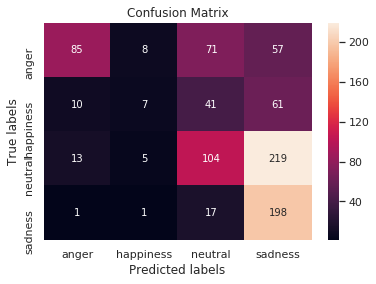


 Classification Report 
              precision    recall  f1-score   support

      anger       0.78      0.38      0.52       221
  happiness       0.33      0.06      0.10       119
    neutral       0.45      0.30      0.36       341
    sadness       0.37      0.91      0.53       217

avg / total       0.50      0.44      0.40       898
 

Train Epoch: 2 [0/3592 (0%)]	Loss: 1.256995

Train Epoch: 2 [2560/3592 (67%)]	Loss: 1.166723


Train set: Average loss: 0.0050


Train Accuracy: 1763/3592 (49%)


Test set: Average loss: 0.0053, Accuracy: 404/898 (44%)



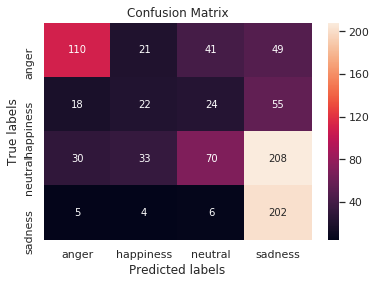


 Classification Report 
              precision    recall  f1-score   support

      anger       0.67      0.50      0.57       221
  happiness       0.28      0.18      0.22       119
    neutral       0.50      0.21      0.29       341
    sadness       0.39      0.93      0.55       217

avg / total       0.49      0.45      0.41       898
 

Train Epoch: 3 [0/3592 (0%)]	Loss: 1.205336

Train Epoch: 3 [2560/3592 (67%)]	Loss: 1.101041


Train set: Average loss: 0.0048


Train Accuracy: 1634/3592 (45%)


Test set: Average loss: 0.0052, Accuracy: 442/898 (49%)



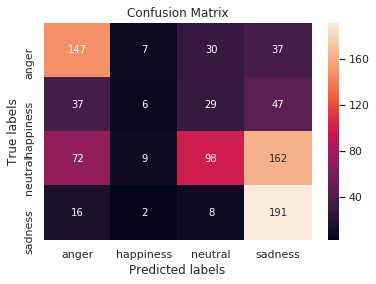


 Classification Report 
              precision    recall  f1-score   support

      anger       0.54      0.67      0.60       221
  happiness       0.25      0.05      0.08       119
    neutral       0.59      0.29      0.39       341
    sadness       0.44      0.88      0.58       217

avg / total       0.50      0.49      0.45       898
 

Train Epoch: 4 [0/3592 (0%)]	Loss: 1.087531

Train Epoch: 4 [2560/3592 (67%)]	Loss: 1.159967


Train set: Average loss: 0.0046


Train Accuracy: 1931/3592 (53%)


Test set: Average loss: 0.0050, Accuracy: 458/898 (51%)



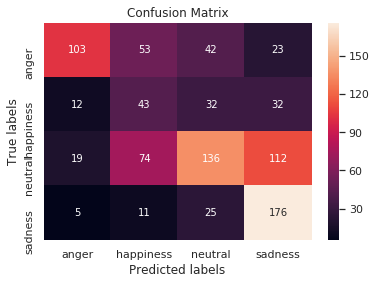


 Classification Report 
              precision    recall  f1-score   support

      anger       0.74      0.47      0.57       221
  happiness       0.24      0.36      0.29       119
    neutral       0.58      0.40      0.47       341
    sadness       0.51      0.81      0.63       217

avg / total       0.56      0.51      0.51       898
 

Train Epoch: 5 [0/3592 (0%)]	Loss: 1.068874

Train Epoch: 5 [2560/3592 (67%)]	Loss: 1.110603


Train set: Average loss: 0.0046


Train Accuracy: 1731/3592 (48%)


Test set: Average loss: 0.0050, Accuracy: 505/898 (56%)



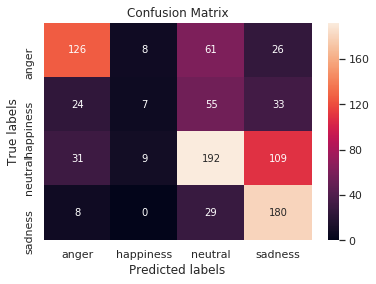


 Classification Report 
              precision    recall  f1-score   support

      anger       0.67      0.57      0.61       221
  happiness       0.29      0.06      0.10       119
    neutral       0.57      0.56      0.57       341
    sadness       0.52      0.83      0.64       217

avg / total       0.54      0.56      0.53       898
 

Train Epoch: 6 [0/3592 (0%)]	Loss: 1.074376

Train Epoch: 6 [2560/3592 (67%)]	Loss: 1.093376


Train set: Average loss: 0.0045


Train Accuracy: 1977/3592 (55%)


Test set: Average loss: 0.0051, Accuracy: 459/898 (51%)



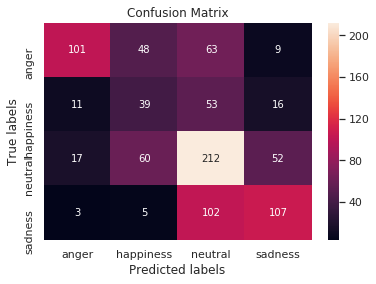


 Classification Report 
              precision    recall  f1-score   support

      anger       0.77      0.46      0.57       221
  happiness       0.26      0.33      0.29       119
    neutral       0.49      0.62      0.55       341
    sadness       0.58      0.49      0.53       217

avg / total       0.55      0.51      0.52       898
 

Train Epoch: 7 [0/3592 (0%)]	Loss: 1.076960

Train Epoch: 7 [2560/3592 (67%)]	Loss: 1.097306


Train set: Average loss: 0.0045


Train Accuracy: 1836/3592 (51%)


Test set: Average loss: 0.0050, Accuracy: 458/898 (51%)



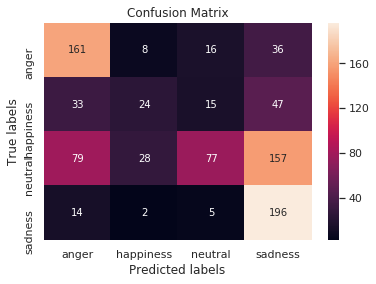


 Classification Report 
              precision    recall  f1-score   support

      anger       0.56      0.73      0.63       221
  happiness       0.39      0.20      0.27       119
    neutral       0.68      0.23      0.34       341
    sadness       0.45      0.90      0.60       217

avg / total       0.56      0.51      0.47       898
 

Train Epoch: 8 [0/3592 (0%)]	Loss: 1.030981

Train Epoch: 8 [2560/3592 (67%)]	Loss: 1.005212


Train set: Average loss: 0.0043


Train Accuracy: 1946/3592 (54%)


Test set: Average loss: 0.0049, Accuracy: 484/898 (53%)



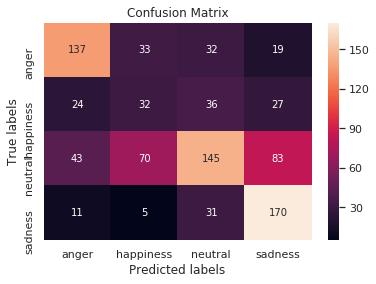


 Classification Report 
              precision    recall  f1-score   support

      anger       0.64      0.62      0.63       221
  happiness       0.23      0.27      0.25       119
    neutral       0.59      0.43      0.50       341
    sadness       0.57      0.78      0.66       217

avg / total       0.55      0.54      0.53       898
 

Train Epoch: 9 [0/3592 (0%)]	Loss: 1.010644

Train Epoch: 9 [2560/3592 (67%)]	Loss: 1.011350


Train set: Average loss: 0.0043


Train Accuracy: 1984/3592 (55%)


Test set: Average loss: 0.0050, Accuracy: 455/898 (50%)



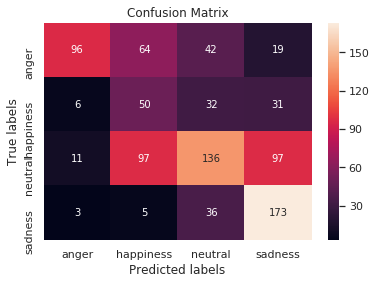


 Classification Report 
              precision    recall  f1-score   support

      anger       0.83      0.43      0.57       221
  happiness       0.23      0.42      0.30       119
    neutral       0.55      0.40      0.46       341
    sadness       0.54      0.80      0.64       217

avg / total       0.57      0.51      0.51       898
 

Train Epoch: 10 [0/3592 (0%)]	Loss: 1.049625

Train Epoch: 10 [2560/3592 (67%)]	Loss: 1.010366


Train set: Average loss: 0.0044


Train Accuracy: 1926/3592 (53%)


Test set: Average loss: 0.0048, Accuracy: 471/898 (52%)



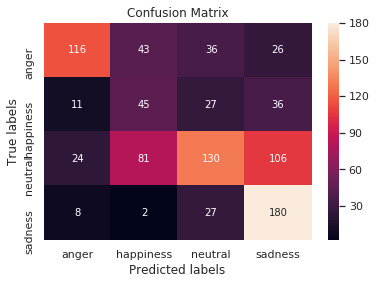


 Classification Report 
              precision    recall  f1-score   support

      anger       0.73      0.52      0.61       221
  happiness       0.26      0.38      0.31       119
    neutral       0.59      0.38      0.46       341
    sadness       0.52      0.83      0.64       217

avg / total       0.56      0.52      0.52       898
 

Train Epoch: 11 [0/3592 (0%)]	Loss: 0.933328

Train Epoch: 11 [2560/3592 (67%)]	Loss: 1.086324


Train set: Average loss: 0.0044


Train Accuracy: 1938/3592 (53%)


Test set: Average loss: 0.0049, Accuracy: 476/898 (53%)



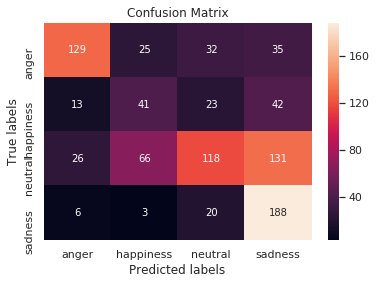


 Classification Report 
              precision    recall  f1-score   support

      anger       0.74      0.58      0.65       221
  happiness       0.30      0.34      0.32       119
    neutral       0.61      0.35      0.44       341
    sadness       0.47      0.87      0.61       217

avg / total       0.57      0.53      0.52       898
 

Train Epoch: 12 [0/3592 (0%)]	Loss: 1.028216

Train Epoch: 12 [2560/3592 (67%)]	Loss: 1.052274


Train set: Average loss: 0.0045


Train Accuracy: 1942/3592 (54%)


Test set: Average loss: 0.0047, Accuracy: 499/898 (55%)



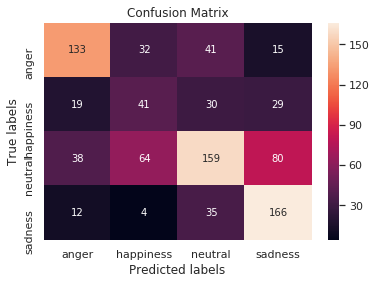


 Classification Report 
              precision    recall  f1-score   support

      anger       0.66      0.60      0.63       221
  happiness       0.29      0.34      0.32       119
    neutral       0.60      0.47      0.52       341
    sadness       0.57      0.76      0.65       217

avg / total       0.57      0.56      0.55       898
 

Train Epoch: 13 [0/3592 (0%)]	Loss: 1.020639

Train Epoch: 13 [2560/3592 (67%)]	Loss: 1.037563


Train set: Average loss: 0.0043


Train Accuracy: 1820/3592 (50%)


Test set: Average loss: 0.0054, Accuracy: 487/898 (54%)



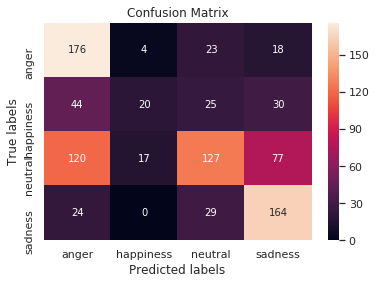


 Classification Report 
              precision    recall  f1-score   support

      anger       0.48      0.80      0.60       221
  happiness       0.49      0.17      0.25       119
    neutral       0.62      0.37      0.47       341
    sadness       0.57      0.76      0.65       217

avg / total       0.56      0.54      0.51       898
 

Train Epoch: 14 [0/3592 (0%)]	Loss: 1.198589

Train Epoch: 14 [2560/3592 (67%)]	Loss: 1.075313


Train set: Average loss: 0.0047


Train Accuracy: 1940/3592 (54%)


Test set: Average loss: 0.0049, Accuracy: 465/898 (51%)



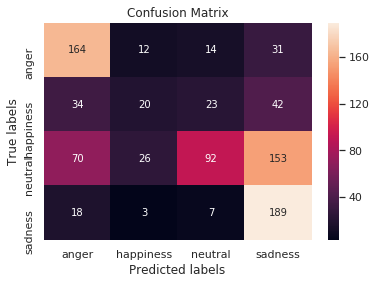


 Classification Report 
              precision    recall  f1-score   support

      anger       0.57      0.74      0.65       221
  happiness       0.33      0.17      0.22       119
    neutral       0.68      0.27      0.39       341
    sadness       0.46      0.87      0.60       217

avg / total       0.55      0.52      0.48       898
 

Train Epoch: 15 [0/3592 (0%)]	Loss: 1.090557

Train Epoch: 15 [2560/3592 (67%)]	Loss: 1.084208


Train set: Average loss: 0.0044


Train Accuracy: 1909/3592 (53%)


Test set: Average loss: 0.0049, Accuracy: 467/898 (52%)



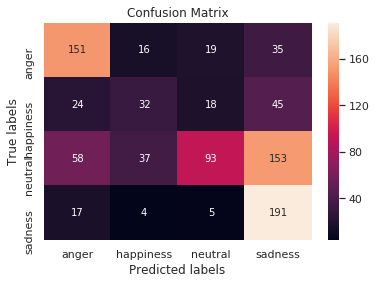


 Classification Report 
              precision    recall  f1-score   support

      anger       0.60      0.68      0.64       221
  happiness       0.36      0.27      0.31       119
    neutral       0.69      0.27      0.39       341
    sadness       0.45      0.88      0.60       217

avg / total       0.57      0.52      0.49       898
 

Train Epoch: 16 [0/3592 (0%)]	Loss: 1.088712

Train Epoch: 16 [2560/3592 (67%)]	Loss: 1.066471


Train set: Average loss: 0.0043


Train Accuracy: 1900/3592 (52%)


Test set: Average loss: 0.0047, Accuracy: 471/898 (52%)



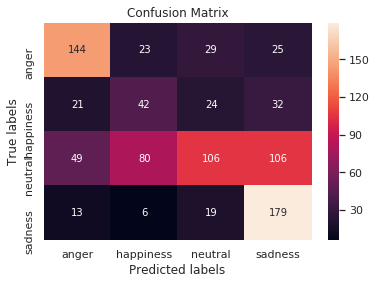


 Classification Report 
              precision    recall  f1-score   support

      anger       0.63      0.65      0.64       221
  happiness       0.28      0.35      0.31       119
    neutral       0.60      0.31      0.41       341
    sadness       0.52      0.82      0.64       217

avg / total       0.55      0.52      0.51       898
 

Train Epoch: 17 [0/3592 (0%)]	Loss: 0.990001

Train Epoch: 17 [2560/3592 (67%)]	Loss: 0.962275


Train set: Average loss: 0.0043


Train Accuracy: 1839/3592 (51%)


Test set: Average loss: 0.0048, Accuracy: 488/898 (54%)



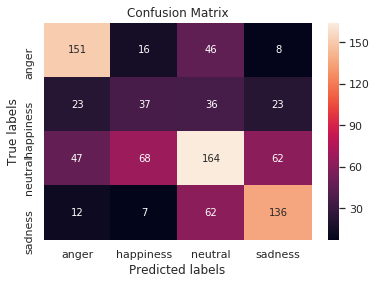


 Classification Report 
              precision    recall  f1-score   support

      anger       0.65      0.68      0.67       221
  happiness       0.29      0.31      0.30       119
    neutral       0.53      0.48      0.51       341
    sadness       0.59      0.63      0.61       217

avg / total       0.54      0.54      0.54       898
 

Train Epoch: 18 [0/3592 (0%)]	Loss: 0.983371

Train Epoch: 18 [2560/3592 (67%)]	Loss: 1.068665


Train set: Average loss: 0.0043


Train Accuracy: 2048/3592 (57%)


Test set: Average loss: 0.0047, Accuracy: 499/898 (55%)



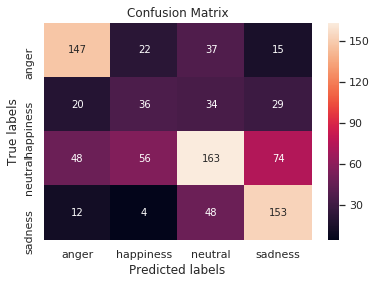


 Classification Report 
              precision    recall  f1-score   support

      anger       0.65      0.67      0.66       221
  happiness       0.31      0.30      0.30       119
    neutral       0.58      0.48      0.52       341
    sadness       0.56      0.71      0.63       217

avg / total       0.56      0.56      0.55       898
 

Train Epoch: 19 [0/3592 (0%)]	Loss: 0.987703

Train Epoch: 19 [2560/3592 (67%)]	Loss: 0.982026


Train set: Average loss: 0.0042


Train Accuracy: 2039/3592 (56%)


Test set: Average loss: 0.0047, Accuracy: 502/898 (55%)



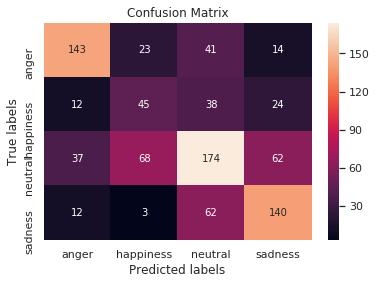


 Classification Report 
              precision    recall  f1-score   support

      anger       0.70      0.65      0.67       221
  happiness       0.32      0.38      0.35       119
    neutral       0.55      0.51      0.53       341
    sadness       0.58      0.65      0.61       217

avg / total       0.57      0.56      0.56       898
 

Train Epoch: 20 [0/3592 (0%)]	Loss: 1.025376

Train Epoch: 20 [2560/3592 (67%)]	Loss: 1.007668


Train set: Average loss: 0.0042


Train Accuracy: 2123/3592 (59%)


Test set: Average loss: 0.0050, Accuracy: 474/898 (52%)



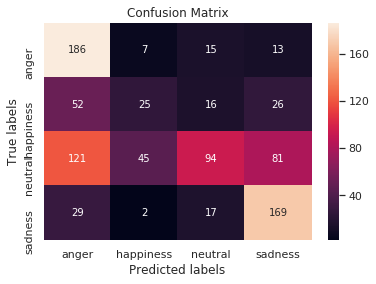


 Classification Report 
              precision    recall  f1-score   support

      anger       0.48      0.84      0.61       221
  happiness       0.32      0.21      0.25       119
    neutral       0.66      0.28      0.39       341
    sadness       0.58      0.78      0.67       217

avg / total       0.55      0.53      0.49       898
 

Train Epoch: 21 [0/3592 (0%)]	Loss: 1.033056

Train Epoch: 21 [2560/3592 (67%)]	Loss: 1.001090


Train set: Average loss: 0.0042


Train Accuracy: 1971/3592 (54%)


Test set: Average loss: 0.0048, Accuracy: 498/898 (55%)



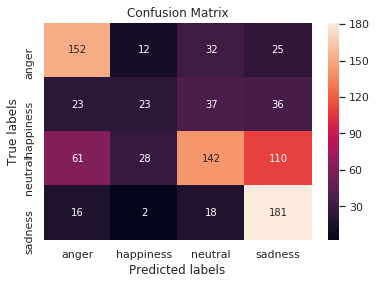


 Classification Report 
              precision    recall  f1-score   support

      anger       0.60      0.69      0.64       221
  happiness       0.35      0.19      0.25       119
    neutral       0.62      0.42      0.50       341
    sadness       0.51      0.83      0.64       217

avg / total       0.56      0.55      0.53       898
 

Train Epoch: 22 [0/3592 (0%)]	Loss: 0.975882

Train Epoch: 22 [2560/3592 (67%)]	Loss: 1.092573


Train set: Average loss: 0.0041


Train Accuracy: 2087/3592 (58%)


Test set: Average loss: 0.0047, Accuracy: 471/898 (52%)



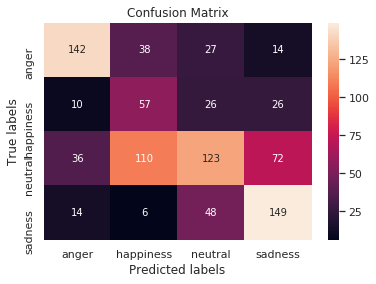


 Classification Report 
              precision    recall  f1-score   support

      anger       0.70      0.64      0.67       221
  happiness       0.27      0.48      0.35       119
    neutral       0.55      0.36      0.44       341
    sadness       0.57      0.69      0.62       217

avg / total       0.56      0.52      0.53       898
 

Train Epoch: 23 [0/3592 (0%)]	Loss: 1.084879

Train Epoch: 23 [2560/3592 (67%)]	Loss: 0.932089


Train set: Average loss: 0.0043


Train Accuracy: 1951/3592 (54%)


Test set: Average loss: 0.0048, Accuracy: 472/898 (52%)



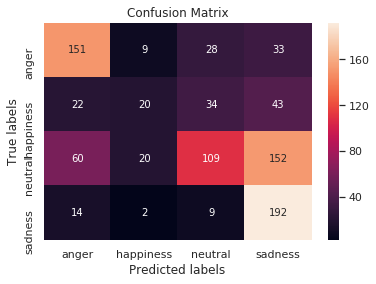


 Classification Report 
              precision    recall  f1-score   support

      anger       0.61      0.68      0.65       221
  happiness       0.39      0.17      0.24       119
    neutral       0.61      0.32      0.42       341
    sadness       0.46      0.88      0.60       217

avg / total       0.54      0.53      0.49       898
 

Train Epoch: 24 [0/3592 (0%)]	Loss: 0.988630

Train Epoch: 24 [2560/3592 (67%)]	Loss: 1.045156


Train set: Average loss: 0.0043


Train Accuracy: 1991/3592 (55%)


Test set: Average loss: 0.0047, Accuracy: 514/898 (57%)



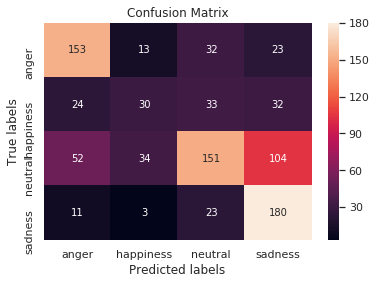


 Classification Report 
              precision    recall  f1-score   support

      anger       0.64      0.69      0.66       221
  happiness       0.38      0.25      0.30       119
    neutral       0.63      0.44      0.52       341
    sadness       0.53      0.83      0.65       217

avg / total       0.57      0.57      0.56       898
 

Train Epoch: 25 [0/3592 (0%)]	Loss: 1.058432

Train Epoch: 25 [2560/3592 (67%)]	Loss: 0.980662


Train set: Average loss: 0.0041


Train Accuracy: 2132/3592 (59%)


Test set: Average loss: 0.0046, Accuracy: 509/898 (56%)



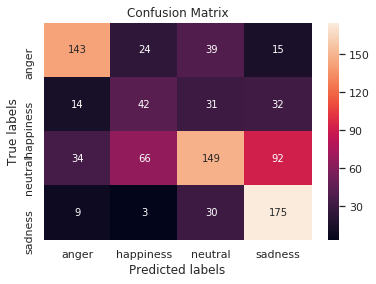


 Classification Report 
              precision    recall  f1-score   support

      anger       0.71      0.65      0.68       221
  happiness       0.31      0.35      0.33       119
    neutral       0.60      0.44      0.51       341
    sadness       0.56      0.81      0.66       217

avg / total       0.58      0.57      0.56       898
 

Train Epoch: 26 [0/3592 (0%)]	Loss: 0.926238

Train Epoch: 26 [2560/3592 (67%)]	Loss: 0.983355


Train set: Average loss: 0.0040


Train Accuracy: 2102/3592 (58%)


Test set: Average loss: 0.0047, Accuracy: 526/898 (58%)



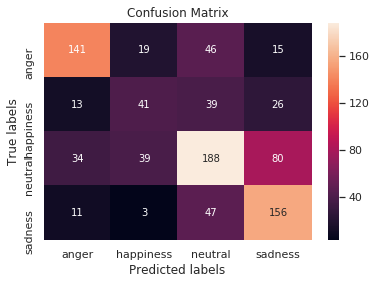


 Classification Report 
              precision    recall  f1-score   support

      anger       0.71      0.64      0.67       221
  happiness       0.40      0.34      0.37       119
    neutral       0.59      0.55      0.57       341
    sadness       0.56      0.72      0.63       217

avg / total       0.59      0.59      0.58       898
 

Train Epoch: 27 [0/3592 (0%)]	Loss: 0.934241

Train Epoch: 27 [2560/3592 (67%)]	Loss: 0.964889


Train set: Average loss: 0.0039


Train Accuracy: 2147/3592 (59%)


Test set: Average loss: 0.0046, Accuracy: 494/898 (55%)



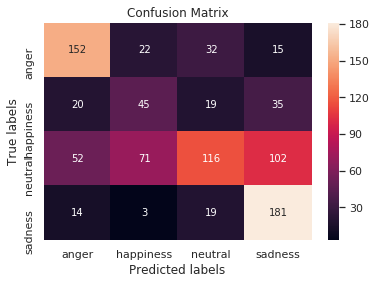


 Classification Report 
              precision    recall  f1-score   support

      anger       0.64      0.69      0.66       221
  happiness       0.32      0.38      0.35       119
    neutral       0.62      0.34      0.44       341
    sadness       0.54      0.83      0.66       217

avg / total       0.57      0.55      0.54       898
 

Train Epoch: 28 [0/3592 (0%)]	Loss: 0.953508

Train Epoch: 28 [2560/3592 (67%)]	Loss: 1.006934


Train set: Average loss: 0.0040


Train Accuracy: 2059/3592 (57%)


Test set: Average loss: 0.0048, Accuracy: 531/898 (59%)



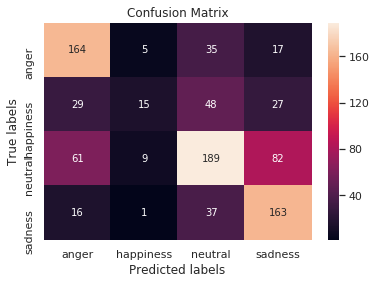


 Classification Report 
              precision    recall  f1-score   support

      anger       0.61      0.74      0.67       221
  happiness       0.50      0.13      0.20       119
    neutral       0.61      0.55      0.58       341
    sadness       0.56      0.75      0.64       217

avg / total       0.58      0.59      0.57       898
 

Train Epoch: 29 [0/3592 (0%)]	Loss: 1.145119

Train Epoch: 29 [2560/3592 (67%)]	Loss: 0.999214


Train set: Average loss: 0.0041


Train Accuracy: 2139/3592 (59%)


Test set: Average loss: 0.0047, Accuracy: 475/898 (52%)



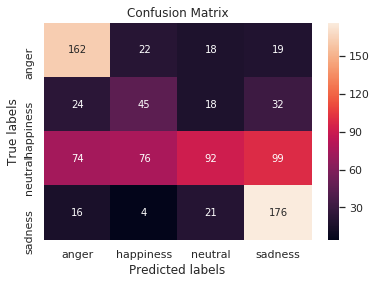


 Classification Report 
              precision    recall  f1-score   support

      anger       0.59      0.73      0.65       221
  happiness       0.31      0.38      0.34       119
    neutral       0.62      0.27      0.38       341
    sadness       0.54      0.81      0.65       217

avg / total       0.55      0.53      0.50       898
 

Train Epoch: 30 [0/3592 (0%)]	Loss: 0.941421

Train Epoch: 30 [2560/3592 (67%)]	Loss: 0.990427


Train set: Average loss: 0.0041


Train Accuracy: 2121/3592 (59%)


Test set: Average loss: 0.0047, Accuracy: 523/898 (58%)



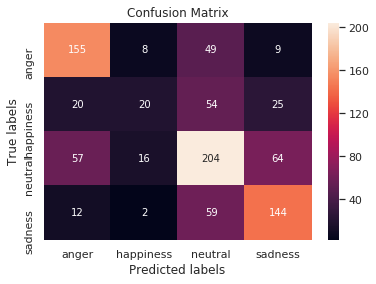


 Classification Report 
              precision    recall  f1-score   support

      anger       0.64      0.70      0.67       221
  happiness       0.43      0.17      0.24       119
    neutral       0.56      0.60      0.58       341
    sadness       0.60      0.66      0.63       217

avg / total       0.57      0.58      0.57       898
 

Train Epoch: 31 [0/3592 (0%)]	Loss: 0.950900

Train Epoch: 31 [2560/3592 (67%)]	Loss: 0.964974


Train set: Average loss: 0.0041


Train Accuracy: 2159/3592 (60%)


Test set: Average loss: 0.0048, Accuracy: 489/898 (54%)



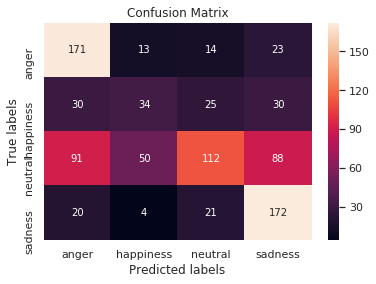


 Classification Report 
              precision    recall  f1-score   support

      anger       0.55      0.77      0.64       221
  happiness       0.34      0.29      0.31       119
    neutral       0.65      0.33      0.44       341
    sadness       0.55      0.79      0.65       217

avg / total       0.56      0.54      0.52       898
 

Train Epoch: 32 [0/3592 (0%)]	Loss: 1.045582

Train Epoch: 32 [2560/3592 (67%)]	Loss: 0.956234


Train set: Average loss: 0.0040


Train Accuracy: 2068/3592 (57%)


Test set: Average loss: 0.0048, Accuracy: 513/898 (57%)



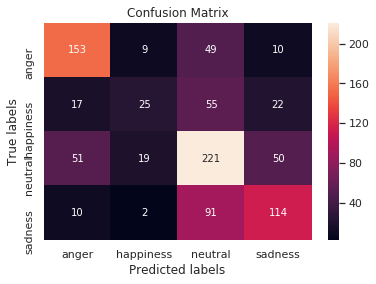


 Classification Report 
              precision    recall  f1-score   support

      anger       0.66      0.69      0.68       221
  happiness       0.45      0.21      0.29       119
    neutral       0.53      0.65      0.58       341
    sadness       0.58      0.53      0.55       217

avg / total       0.57      0.57      0.56       898
 

Train Epoch: 33 [0/3592 (0%)]	Loss: 0.992315

Train Epoch: 33 [2560/3592 (67%)]	Loss: 1.110214


Train set: Average loss: 0.0043


Train Accuracy: 2064/3592 (57%)


Test set: Average loss: 0.0046, Accuracy: 487/898 (54%)



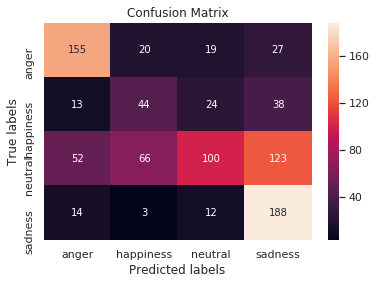


 Classification Report 
              precision    recall  f1-score   support

      anger       0.66      0.70      0.68       221
  happiness       0.33      0.37      0.35       119
    neutral       0.65      0.29      0.40       341
    sadness       0.50      0.87      0.63       217

avg / total       0.57      0.54      0.52       898
 

Train Epoch: 34 [0/3592 (0%)]	Loss: 0.936103

Train Epoch: 34 [2560/3592 (67%)]	Loss: 0.994131


Train set: Average loss: 0.0041


Train Accuracy: 2124/3592 (59%)


Test set: Average loss: 0.0047, Accuracy: 525/898 (58%)



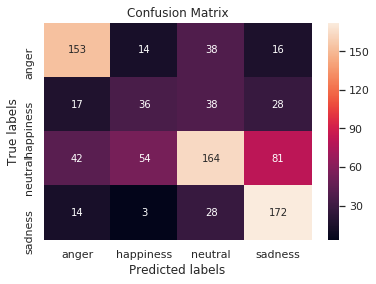


 Classification Report 
              precision    recall  f1-score   support

      anger       0.68      0.69      0.68       221
  happiness       0.34      0.30      0.32       119
    neutral       0.61      0.48      0.54       341
    sadness       0.58      0.79      0.67       217

avg / total       0.58      0.58      0.58       898
 

Train Epoch: 35 [0/3592 (0%)]	Loss: 1.051605

Train Epoch: 35 [2560/3592 (67%)]	Loss: 0.914923


Train set: Average loss: 0.0041


Train Accuracy: 2057/3592 (57%)


Test set: Average loss: 0.0049, Accuracy: 498/898 (55%)



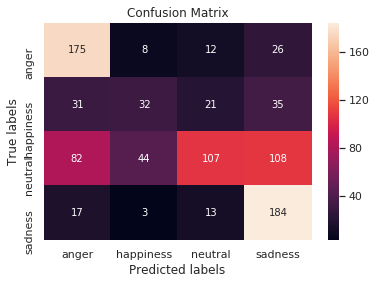


 Classification Report 
              precision    recall  f1-score   support

      anger       0.57      0.79      0.67       221
  happiness       0.37      0.27      0.31       119
    neutral       0.70      0.31      0.43       341
    sadness       0.52      0.85      0.65       217

avg / total       0.58      0.55      0.53       898
 

Train Epoch: 36 [0/3592 (0%)]	Loss: 1.041700

Train Epoch: 36 [2560/3592 (67%)]	Loss: 0.935383


Train set: Average loss: 0.0040


Train Accuracy: 2069/3592 (57%)


Test set: Average loss: 0.0047, Accuracy: 508/898 (56%)



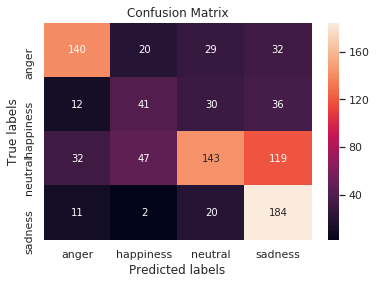


 Classification Report 
              precision    recall  f1-score   support

      anger       0.72      0.63      0.67       221
  happiness       0.37      0.34      0.36       119
    neutral       0.64      0.42      0.51       341
    sadness       0.50      0.85      0.63       217

avg / total       0.59      0.57      0.56       898
 

Train Epoch: 37 [0/3592 (0%)]	Loss: 0.937522

Train Epoch: 37 [2560/3592 (67%)]	Loss: 0.911534


Train set: Average loss: 0.0040


Train Accuracy: 2074/3592 (57%)


Test set: Average loss: 0.0047, Accuracy: 537/898 (59%)



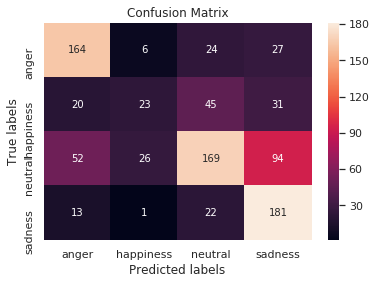


 Classification Report 
              precision    recall  f1-score   support

      anger       0.66      0.74      0.70       221
  happiness       0.41      0.19      0.26       119
    neutral       0.65      0.50      0.56       341
    sadness       0.54      0.83      0.66       217

avg / total       0.59      0.60      0.58       898
 

Train Epoch: 38 [0/3592 (0%)]	Loss: 0.975492

Train Epoch: 38 [2560/3592 (67%)]	Loss: 0.928477


Train set: Average loss: 0.0040


Train Accuracy: 2157/3592 (60%)


Test set: Average loss: 0.0046, Accuracy: 514/898 (57%)



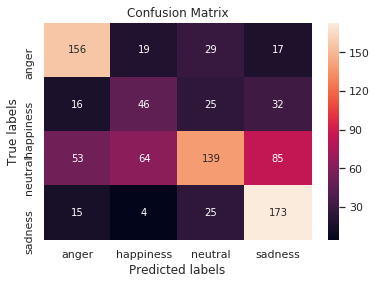


 Classification Report 
              precision    recall  f1-score   support

      anger       0.65      0.71      0.68       221
  happiness       0.35      0.39      0.37       119
    neutral       0.64      0.41      0.50       341
    sadness       0.56      0.80      0.66       217

avg / total       0.58      0.57      0.56       898
 

Train Epoch: 39 [0/3592 (0%)]	Loss: 0.864962

Train Epoch: 39 [2560/3592 (67%)]	Loss: 0.904697


Train set: Average loss: 0.0040


Train Accuracy: 2143/3592 (59%)


Test set: Average loss: 0.0047, Accuracy: 493/898 (54%)



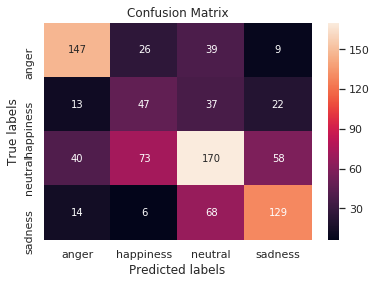


 Classification Report 
              precision    recall  f1-score   support

      anger       0.69      0.67      0.68       221
  happiness       0.31      0.39      0.35       119
    neutral       0.54      0.50      0.52       341
    sadness       0.59      0.59      0.59       217

avg / total       0.56      0.55      0.55       898
 

Train Epoch: 40 [0/3592 (0%)]	Loss: 0.955316

Train Epoch: 40 [2560/3592 (67%)]	Loss: 0.885907


Train set: Average loss: 0.0039


Train Accuracy: 2107/3592 (58%)


Test set: Average loss: 0.0047, Accuracy: 488/898 (54%)



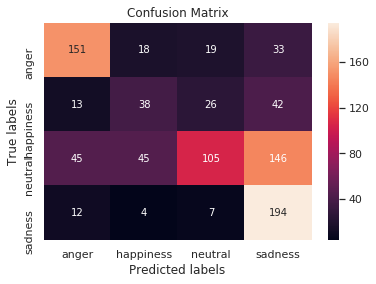


 Classification Report 
              precision    recall  f1-score   support

      anger       0.68      0.68      0.68       221
  happiness       0.36      0.32      0.34       119
    neutral       0.67      0.31      0.42       341
    sadness       0.47      0.89      0.61       217

avg / total       0.58      0.54      0.52       898
 

Train Epoch: 41 [0/3592 (0%)]	Loss: 0.956418

Train Epoch: 41 [2560/3592 (67%)]	Loss: 0.906085


Train set: Average loss: 0.0041


Train Accuracy: 2127/3592 (59%)


Test set: Average loss: 0.0047, Accuracy: 526/898 (58%)



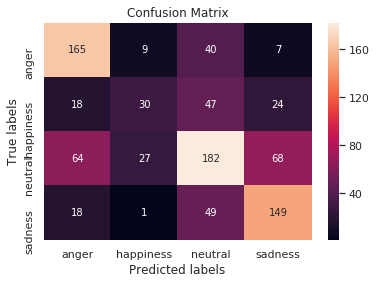


 Classification Report 
              precision    recall  f1-score   support

      anger       0.62      0.75      0.68       221
  happiness       0.45      0.25      0.32       119
    neutral       0.57      0.53      0.55       341
    sadness       0.60      0.69      0.64       217

avg / total       0.58      0.59      0.57       898
 

Train Epoch: 42 [0/3592 (0%)]	Loss: 0.884880

Train Epoch: 42 [2560/3592 (67%)]	Loss: 0.892352


Train set: Average loss: 0.0040


Train Accuracy: 2144/3592 (59%)


Test set: Average loss: 0.0046, Accuracy: 522/898 (58%)



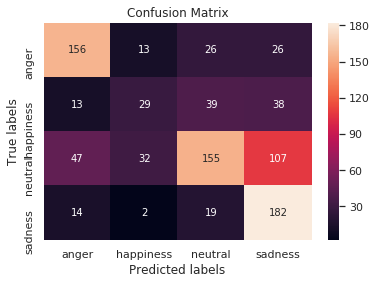


 Classification Report 
              precision    recall  f1-score   support

      anger       0.68      0.71      0.69       221
  happiness       0.38      0.24      0.30       119
    neutral       0.65      0.45      0.53       341
    sadness       0.52      0.84      0.64       217

avg / total       0.59      0.58      0.57       898
 

Train Epoch: 43 [0/3592 (0%)]	Loss: 0.930870

Train Epoch: 43 [2560/3592 (67%)]	Loss: 1.015323


Train set: Average loss: 0.0039


Train Accuracy: 2176/3592 (60%)


Test set: Average loss: 0.0046, Accuracy: 524/898 (58%)



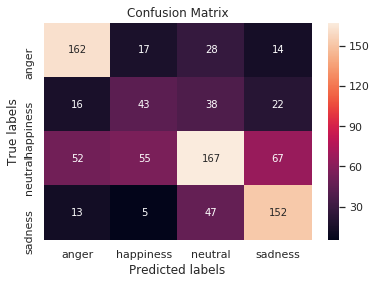


 Classification Report 
              precision    recall  f1-score   support

      anger       0.67      0.73      0.70       221
  happiness       0.36      0.36      0.36       119
    neutral       0.60      0.49      0.54       341
    sadness       0.60      0.70      0.64       217

avg / total       0.58      0.58      0.58       898
 

Train Epoch: 44 [0/3592 (0%)]	Loss: 0.933822

Train Epoch: 44 [2560/3592 (67%)]	Loss: 0.898933


Train set: Average loss: 0.0038


Train Accuracy: 2177/3592 (60%)


Test set: Average loss: 0.0046, Accuracy: 525/898 (58%)



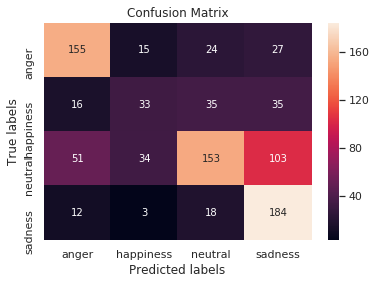


 Classification Report 
              precision    recall  f1-score   support

      anger       0.66      0.70      0.68       221
  happiness       0.39      0.28      0.32       119
    neutral       0.67      0.45      0.54       341
    sadness       0.53      0.85      0.65       217

avg / total       0.59      0.58      0.57       898
 

Train Epoch: 45 [0/3592 (0%)]	Loss: 0.974309

Train Epoch: 45 [2560/3592 (67%)]	Loss: 1.017403


Train set: Average loss: 0.0039


Train Accuracy: 2173/3592 (60%)


Test set: Average loss: 0.0046, Accuracy: 531/898 (59%)



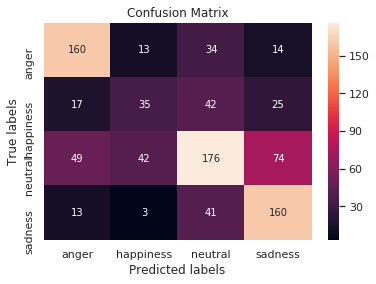


 Classification Report 
              precision    recall  f1-score   support

      anger       0.67      0.72      0.70       221
  happiness       0.38      0.29      0.33       119
    neutral       0.60      0.52      0.56       341
    sadness       0.59      0.74      0.65       217

avg / total       0.58      0.59      0.58       898
 

Train Epoch: 46 [0/3592 (0%)]	Loss: 0.910894

Train Epoch: 46 [2560/3592 (67%)]	Loss: 0.960680


Train set: Average loss: 0.0040


Train Accuracy: 2201/3592 (61%)


Test set: Average loss: 0.0047, Accuracy: 529/898 (58%)



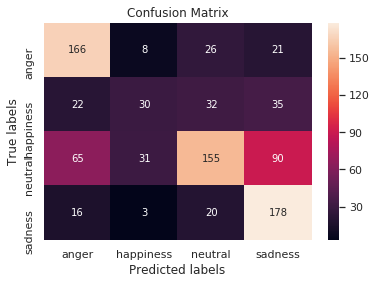


 Classification Report 
              precision    recall  f1-score   support

      anger       0.62      0.75      0.68       221
  happiness       0.42      0.25      0.31       119
    neutral       0.67      0.45      0.54       341
    sadness       0.55      0.82      0.66       217

avg / total       0.59      0.59      0.57       898
 

Train Epoch: 47 [0/3592 (0%)]	Loss: 0.879073

Train Epoch: 47 [2560/3592 (67%)]	Loss: 0.939236


Train set: Average loss: 0.0039


Train Accuracy: 2138/3592 (59%)


Test set: Average loss: 0.0045, Accuracy: 517/898 (57%)



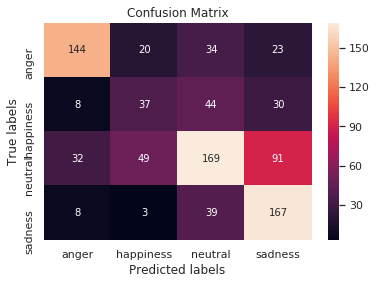


 Classification Report 
              precision    recall  f1-score   support

      anger       0.75      0.65      0.70       221
  happiness       0.34      0.31      0.32       119
    neutral       0.59      0.50      0.54       341
    sadness       0.54      0.77      0.63       217

avg / total       0.58      0.58      0.57       898
 

Train Epoch: 48 [0/3592 (0%)]	Loss: 0.962927

Train Epoch: 48 [2560/3592 (67%)]	Loss: 0.858748


Train set: Average loss: 0.0039


Train Accuracy: 2190/3592 (60%)


Test set: Average loss: 0.0046, Accuracy: 514/898 (57%)



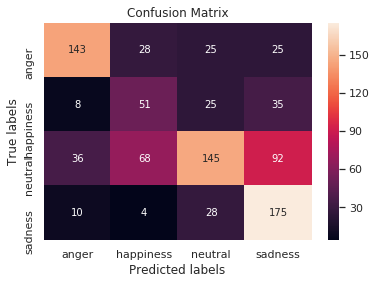


 Classification Report 
              precision    recall  f1-score   support

      anger       0.73      0.65      0.68       221
  happiness       0.34      0.43      0.38       119
    neutral       0.65      0.43      0.51       341
    sadness       0.54      0.81      0.64       217

avg / total       0.60      0.57      0.57       898
 

Train Epoch: 49 [0/3592 (0%)]	Loss: 0.973211

Train Epoch: 49 [2560/3592 (67%)]	Loss: 0.954000


Train set: Average loss: 0.0039


Train Accuracy: 2130/3592 (59%)


Test set: Average loss: 0.0046, Accuracy: 533/898 (59%)



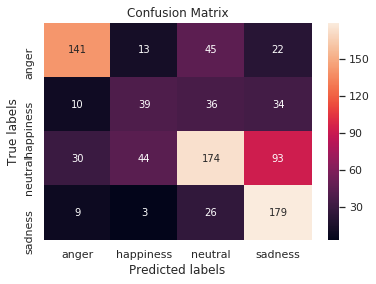


 Classification Report 
              precision    recall  f1-score   support

      anger       0.74      0.64      0.69       221
  happiness       0.39      0.33      0.36       119
    neutral       0.62      0.51      0.56       341
    sadness       0.55      0.82      0.66       217

avg / total       0.60      0.59      0.59       898
 

Train Epoch: 50 [0/3592 (0%)]	Loss: 0.895792

Train Epoch: 50 [2560/3592 (67%)]	Loss: 0.859561


Train set: Average loss: 0.0039


Train Accuracy: 2196/3592 (61%)


Test set: Average loss: 0.0046, Accuracy: 496/898 (55%)



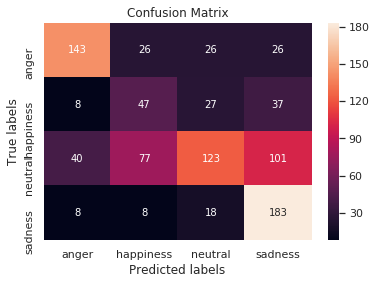


 Classification Report 
              precision    recall  f1-score   support

      anger       0.72      0.65      0.68       221
  happiness       0.30      0.39      0.34       119
    neutral       0.63      0.36      0.46       341
    sadness       0.53      0.84      0.65       217

avg / total       0.58      0.55      0.54       898
 

Train Epoch: 51 [0/3592 (0%)]	Loss: 0.848228

Train Epoch: 51 [2560/3592 (67%)]	Loss: 0.934156


Train set: Average loss: 0.0038


Train Accuracy: 2165/3592 (60%)


Test set: Average loss: 0.0046, Accuracy: 528/898 (58%)



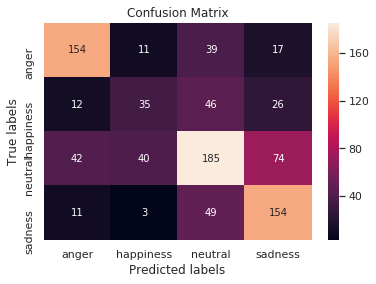


 Classification Report 
              precision    recall  f1-score   support

      anger       0.70      0.70      0.70       221
  happiness       0.39      0.29      0.34       119
    neutral       0.58      0.54      0.56       341
    sadness       0.57      0.71      0.63       217

avg / total       0.58      0.59      0.58       898
 

Train Epoch: 52 [0/3592 (0%)]	Loss: 0.978833

Train Epoch: 52 [2560/3592 (67%)]	Loss: 0.868757


Train set: Average loss: 0.0039


Train Accuracy: 2214/3592 (61%)


Test set: Average loss: 0.0047, Accuracy: 496/898 (55%)



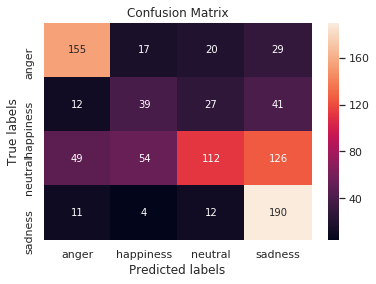


 Classification Report 
              precision    recall  f1-score   support

      anger       0.68      0.70      0.69       221
  happiness       0.34      0.33      0.33       119
    neutral       0.65      0.33      0.44       341
    sadness       0.49      0.88      0.63       217

avg / total       0.58      0.55      0.53       898
 

Train Epoch: 53 [0/3592 (0%)]	Loss: 0.934759

Train Epoch: 53 [2560/3592 (67%)]	Loss: 0.928669


Train set: Average loss: 0.0038


Train Accuracy: 2185/3592 (60%)


Test set: Average loss: 0.0046, Accuracy: 535/898 (59%)



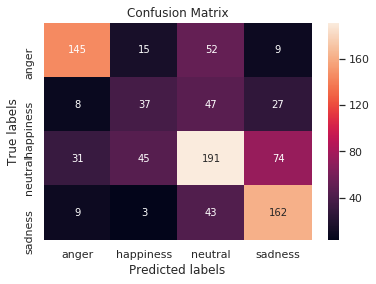


 Classification Report 
              precision    recall  f1-score   support

      anger       0.75      0.66      0.70       221
  happiness       0.37      0.31      0.34       119
    neutral       0.57      0.56      0.57       341
    sadness       0.60      0.75      0.66       217

avg / total       0.60      0.60      0.59       898
 

Train Epoch: 54 [0/3592 (0%)]	Loss: 0.962379

Train Epoch: 54 [2560/3592 (67%)]	Loss: 0.875137


Train set: Average loss: 0.0038


Train Accuracy: 2189/3592 (60%)


Test set: Average loss: 0.0046, Accuracy: 519/898 (57%)



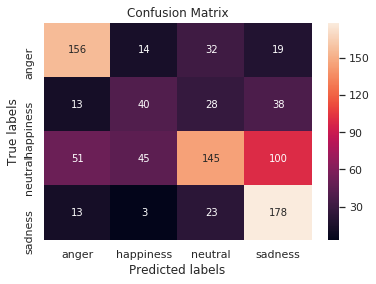


 Classification Report 
              precision    recall  f1-score   support

      anger       0.67      0.71      0.69       221
  happiness       0.39      0.34      0.36       119
    neutral       0.64      0.43      0.51       341
    sadness       0.53      0.82      0.64       217

avg / total       0.59      0.58      0.57       898
 

Train Epoch: 55 [0/3592 (0%)]	Loss: 0.997358

Train Epoch: 55 [2560/3592 (67%)]	Loss: 0.834613


Train set: Average loss: 0.0038


Train Accuracy: 2242/3592 (62%)


Test set: Average loss: 0.0046, Accuracy: 504/898 (56%)



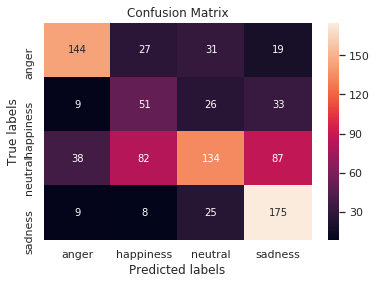


 Classification Report 
              precision    recall  f1-score   support

      anger       0.72      0.65      0.68       221
  happiness       0.30      0.43      0.36       119
    neutral       0.62      0.39      0.48       341
    sadness       0.56      0.81      0.66       217

avg / total       0.59      0.56      0.56       898
 

Train Epoch: 56 [0/3592 (0%)]	Loss: 0.945543

Train Epoch: 56 [2560/3592 (67%)]	Loss: 0.870809


Train set: Average loss: 0.0038


Train Accuracy: 2143/3592 (59%)


Test set: Average loss: 0.0046, Accuracy: 533/898 (59%)



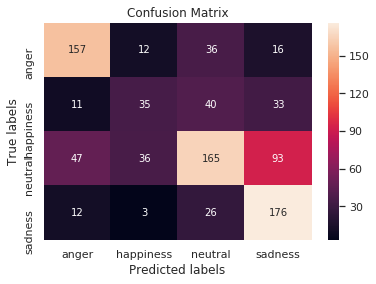


 Classification Report 
              precision    recall  f1-score   support

      anger       0.69      0.71      0.70       221
  happiness       0.41      0.29      0.34       119
    neutral       0.62      0.48      0.54       341
    sadness       0.55      0.81      0.66       217

avg / total       0.59      0.59      0.58       898
 

Train Epoch: 57 [0/3592 (0%)]	Loss: 0.926688

Train Epoch: 57 [2560/3592 (67%)]	Loss: 0.972305


Train set: Average loss: 0.0037


Train Accuracy: 2197/3592 (61%)


Test set: Average loss: 0.0047, Accuracy: 518/898 (57%)



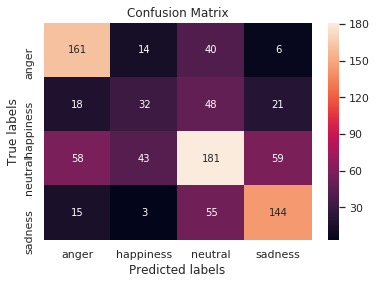


 Classification Report 
              precision    recall  f1-score   support

      anger       0.64      0.73      0.68       221
  happiness       0.35      0.27      0.30       119
    neutral       0.56      0.53      0.54       341
    sadness       0.63      0.66      0.64       217

avg / total       0.57      0.58      0.57       898
 

Train Epoch: 58 [0/3592 (0%)]	Loss: 0.975670

Train Epoch: 58 [2560/3592 (67%)]	Loss: 0.948408


Train set: Average loss: 0.0039


Train Accuracy: 2165/3592 (60%)


Test set: Average loss: 0.0047, Accuracy: 517/898 (57%)



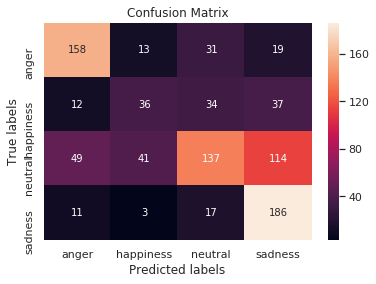


 Classification Report 
              precision    recall  f1-score   support

      anger       0.69      0.71      0.70       221
  happiness       0.39      0.30      0.34       119
    neutral       0.63      0.40      0.49       341
    sadness       0.52      0.86      0.65       217

avg / total       0.58      0.58      0.56       898
 

Train Epoch: 59 [0/3592 (0%)]	Loss: 0.895023

Train Epoch: 59 [2560/3592 (67%)]	Loss: 0.915627


Train set: Average loss: 0.0038


Train Accuracy: 2171/3592 (60%)


Test set: Average loss: 0.0047, Accuracy: 523/898 (58%)



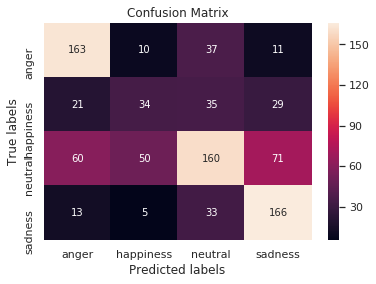


 Classification Report 
              precision    recall  f1-score   support

      anger       0.63      0.74      0.68       221
  happiness       0.34      0.29      0.31       119
    neutral       0.60      0.47      0.53       341
    sadness       0.60      0.76      0.67       217

avg / total       0.58      0.58      0.57       898
 

Train Epoch: 60 [0/3592 (0%)]	Loss: 0.909193

Train Epoch: 60 [2560/3592 (67%)]	Loss: 0.860146


Train set: Average loss: 0.0039


Train Accuracy: 2187/3592 (60%)


Test set: Average loss: 0.0046, Accuracy: 528/898 (58%)



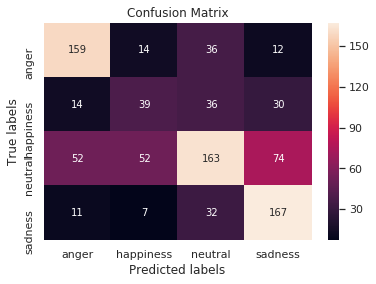


 Classification Report 
              precision    recall  f1-score   support

      anger       0.67      0.72      0.70       221
  happiness       0.35      0.33      0.34       119
    neutral       0.61      0.48      0.54       341
    sadness       0.59      0.77      0.67       217

avg / total       0.59      0.59      0.58       898
 

Train Epoch: 61 [0/3592 (0%)]	Loss: 0.870171

Train Epoch: 61 [2560/3592 (67%)]	Loss: 0.876913


Train set: Average loss: 0.0037


Train Accuracy: 2160/3592 (60%)


Test set: Average loss: 0.0046, Accuracy: 523/898 (58%)



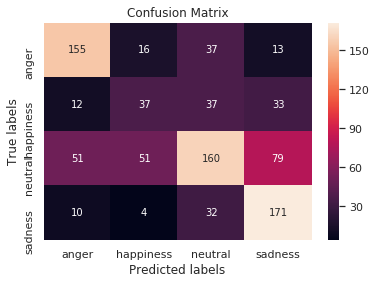


 Classification Report 
              precision    recall  f1-score   support

      anger       0.68      0.70      0.69       221
  happiness       0.34      0.31      0.33       119
    neutral       0.60      0.47      0.53       341
    sadness       0.58      0.79      0.67       217

avg / total       0.58      0.58      0.57       898
 

Train Epoch: 62 [0/3592 (0%)]	Loss: 0.913501

Train Epoch: 62 [2560/3592 (67%)]	Loss: 0.874475


Train set: Average loss: 0.0036


Train Accuracy: 2263/3592 (63%)


Test set: Average loss: 0.0046, Accuracy: 522/898 (58%)



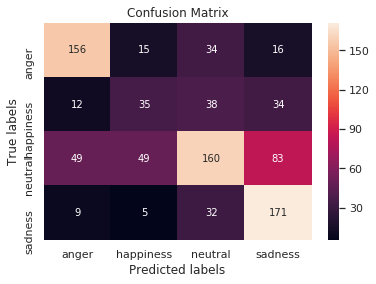


 Classification Report 
              precision    recall  f1-score   support

      anger       0.69      0.71      0.70       221
  happiness       0.34      0.29      0.31       119
    neutral       0.61      0.47      0.53       341
    sadness       0.56      0.79      0.66       217

avg / total       0.58      0.58      0.57       898
 

Train Epoch: 63 [0/3592 (0%)]	Loss: 0.834326

Train Epoch: 63 [2560/3592 (67%)]	Loss: 0.852499


Train set: Average loss: 0.0037


Train Accuracy: 2227/3592 (61%)


Test set: Average loss: 0.0046, Accuracy: 514/898 (57%)



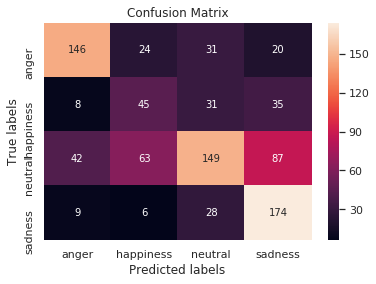


 Classification Report 
              precision    recall  f1-score   support

      anger       0.71      0.66      0.69       221
  happiness       0.33      0.38      0.35       119
    neutral       0.62      0.44      0.51       341
    sadness       0.55      0.80      0.65       217

avg / total       0.59      0.57      0.57       898
 

Train Epoch: 64 [0/3592 (0%)]	Loss: 0.879359

Train Epoch: 64 [2560/3592 (67%)]	Loss: 0.862882


Train set: Average loss: 0.0037


Train Accuracy: 2158/3592 (60%)


Test set: Average loss: 0.0047, Accuracy: 532/898 (59%)



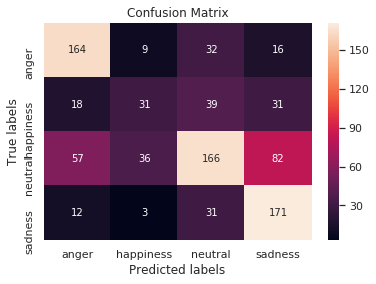


 Classification Report 
              precision    recall  f1-score   support

      anger       0.65      0.74      0.69       221
  happiness       0.39      0.26      0.31       119
    neutral       0.62      0.49      0.55       341
    sadness       0.57      0.79      0.66       217

avg / total       0.59      0.59      0.58       898
 

Train Epoch: 65 [0/3592 (0%)]	Loss: 0.948441

Train Epoch: 65 [2560/3592 (67%)]	Loss: 0.865622


Train set: Average loss: 0.0039


Train Accuracy: 2280/3592 (63%)


Test set: Average loss: 0.0046, Accuracy: 523/898 (58%)



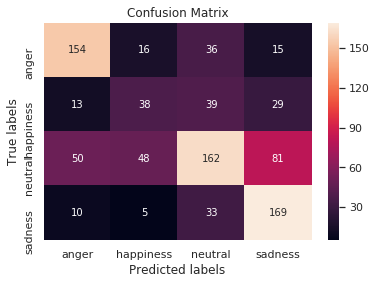


 Classification Report 
              precision    recall  f1-score   support

      anger       0.68      0.70      0.69       221
  happiness       0.36      0.32      0.34       119
    neutral       0.60      0.48      0.53       341
    sadness       0.57      0.78      0.66       217

avg / total       0.58      0.58      0.57       898
 

Train Epoch: 66 [0/3592 (0%)]	Loss: 0.880918

Train Epoch: 66 [2560/3592 (67%)]	Loss: 0.858507


Train set: Average loss: 0.0037


Train Accuracy: 2192/3592 (61%)


Test set: Average loss: 0.0046, Accuracy: 522/898 (58%)



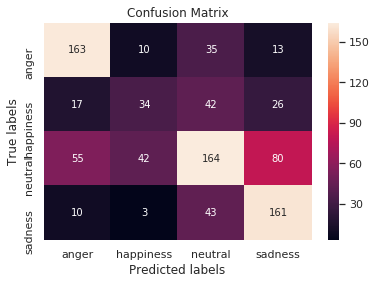


 Classification Report 
              precision    recall  f1-score   support

      anger       0.67      0.74      0.70       221
  happiness       0.38      0.29      0.33       119
    neutral       0.58      0.48      0.52       341
    sadness       0.57      0.74      0.65       217

avg / total       0.57      0.58      0.57       898
 

Train Epoch: 67 [0/3592 (0%)]	Loss: 0.938698

Train Epoch: 67 [2560/3592 (67%)]	Loss: 0.931578


Train set: Average loss: 0.0037


Train Accuracy: 2297/3592 (63%)


Test set: Average loss: 0.0046, Accuracy: 531/898 (59%)



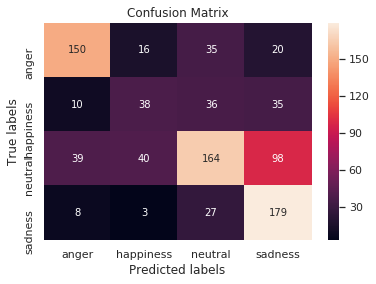


 Classification Report 
              precision    recall  f1-score   support

      anger       0.72      0.68      0.70       221
  happiness       0.39      0.32      0.35       119
    neutral       0.63      0.48      0.54       341
    sadness       0.54      0.82      0.65       217

avg / total       0.60      0.59      0.58       898
 

Train Epoch: 68 [0/3592 (0%)]	Loss: 0.906751

Train Epoch: 68 [2560/3592 (67%)]	Loss: 0.951318


Train set: Average loss: 0.0037


Train Accuracy: 2140/3592 (59%)


Test set: Average loss: 0.0046, Accuracy: 522/898 (58%)



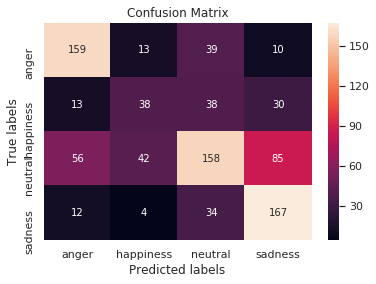


 Classification Report 
              precision    recall  f1-score   support

      anger       0.66      0.72      0.69       221
  happiness       0.39      0.32      0.35       119
    neutral       0.59      0.46      0.52       341
    sadness       0.57      0.77      0.66       217

avg / total       0.58      0.58      0.57       898
 

Train Epoch: 69 [0/3592 (0%)]	Loss: 0.900829

Train Epoch: 69 [2560/3592 (67%)]	Loss: 0.967247


Train set: Average loss: 0.0038


Train Accuracy: 2265/3592 (63%)


Test set: Average loss: 0.0046, Accuracy: 530/898 (59%)



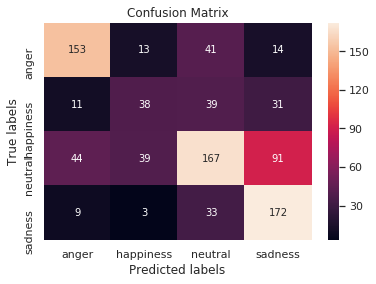


 Classification Report 
              precision    recall  f1-score   support

      anger       0.71      0.69      0.70       221
  happiness       0.41      0.32      0.36       119
    neutral       0.60      0.49      0.54       341
    sadness       0.56      0.79      0.66       217

avg / total       0.59      0.59      0.58       898
 

Train Epoch: 70 [0/3592 (0%)]	Loss: 0.889780

Train Epoch: 70 [2560/3592 (67%)]	Loss: 0.939757


Train set: Average loss: 0.0037


Train Accuracy: 2193/3592 (61%)


Test set: Average loss: 0.0046, Accuracy: 524/898 (58%)



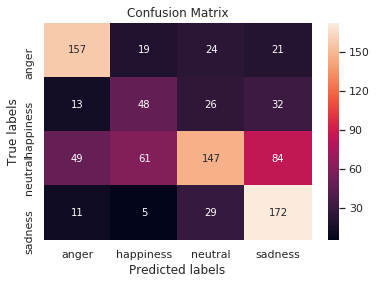


 Classification Report 
              precision    recall  f1-score   support

      anger       0.68      0.71      0.70       221
  happiness       0.36      0.40      0.38       119
    neutral       0.65      0.43      0.52       341
    sadness       0.56      0.79      0.65       217

avg / total       0.60      0.58      0.58       898
 

Train Epoch: 71 [0/3592 (0%)]	Loss: 0.919848

Train Epoch: 71 [2560/3592 (67%)]	Loss: 0.822558


Train set: Average loss: 0.0036


Train Accuracy: 2190/3592 (60%)


Test set: Average loss: 0.0046, Accuracy: 530/898 (59%)



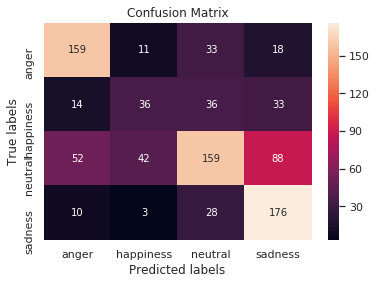


 Classification Report 
              precision    recall  f1-score   support

      anger       0.68      0.72      0.70       221
  happiness       0.39      0.30      0.34       119
    neutral       0.62      0.47      0.53       341
    sadness       0.56      0.81      0.66       217

avg / total       0.59      0.59      0.58       898
 

Train Epoch: 72 [0/3592 (0%)]	Loss: 0.847210

Train Epoch: 72 [2560/3592 (67%)]	Loss: 0.842764


Train set: Average loss: 0.0037


Train Accuracy: 2250/3592 (62%)


Test set: Average loss: 0.0046, Accuracy: 528/898 (58%)



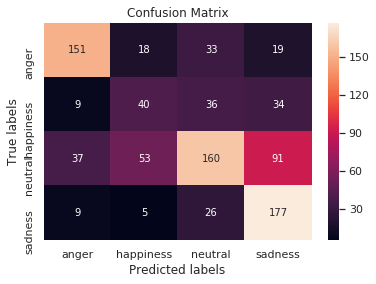


 Classification Report 
              precision    recall  f1-score   support

      anger       0.73      0.68      0.71       221
  happiness       0.34      0.34      0.34       119
    neutral       0.63      0.47      0.54       341
    sadness       0.55      0.82      0.66       217

avg / total       0.60      0.59      0.58       898
 

Train Epoch: 73 [0/3592 (0%)]	Loss: 0.889329

Train Epoch: 73 [2560/3592 (67%)]	Loss: 0.812828


Train set: Average loss: 0.0037


Train Accuracy: 2249/3592 (62%)


Test set: Average loss: 0.0046, Accuracy: 519/898 (57%)



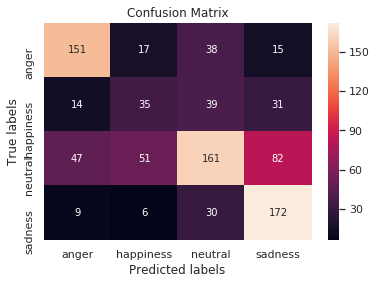


 Classification Report 
              precision    recall  f1-score   support

      anger       0.68      0.68      0.68       221
  happiness       0.32      0.29      0.31       119
    neutral       0.60      0.47      0.53       341
    sadness       0.57      0.79      0.67       217

avg / total       0.58      0.58      0.57       898
 

Train Epoch: 74 [0/3592 (0%)]	Loss: 0.848249

Train Epoch: 74 [2560/3592 (67%)]	Loss: 0.872616


Train set: Average loss: 0.0037


Train Accuracy: 2238/3592 (62%)


Test set: Average loss: 0.0046, Accuracy: 524/898 (58%)



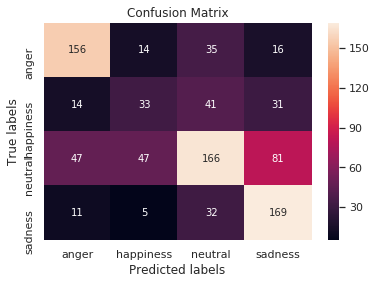


 Classification Report 
              precision    recall  f1-score   support

      anger       0.68      0.71      0.69       221
  happiness       0.33      0.28      0.30       119
    neutral       0.61      0.49      0.54       341
    sadness       0.57      0.78      0.66       217

avg / total       0.58      0.58      0.58       898
 

Train Epoch: 75 [0/3592 (0%)]	Loss: 0.928137

Train Epoch: 75 [2560/3592 (67%)]	Loss: 0.882009


Train set: Average loss: 0.0036


Train Accuracy: 2193/3592 (61%)


Test set: Average loss: 0.0046, Accuracy: 521/898 (58%)



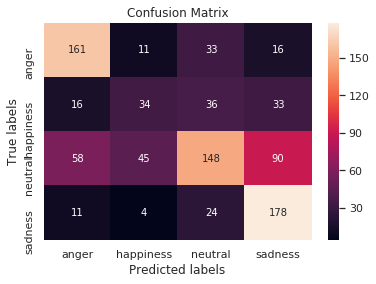


 Classification Report 
              precision    recall  f1-score   support

      anger       0.65      0.73      0.69       221
  happiness       0.36      0.29      0.32       119
    neutral       0.61      0.43      0.51       341
    sadness       0.56      0.82      0.67       217

avg / total       0.58      0.58      0.57       898
 

Train Epoch: 76 [0/3592 (0%)]	Loss: 0.827037

Train Epoch: 76 [2560/3592 (67%)]	Loss: 0.980042


Train set: Average loss: 0.0036


Train Accuracy: 2263/3592 (63%)


Test set: Average loss: 0.0046, Accuracy: 525/898 (58%)



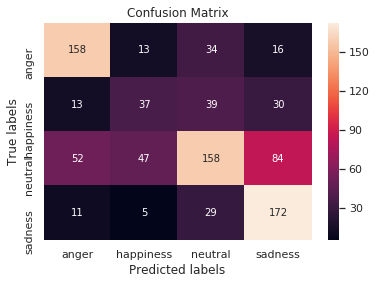


 Classification Report 
              precision    recall  f1-score   support

      anger       0.68      0.71      0.69       221
  happiness       0.36      0.31      0.33       119
    neutral       0.61      0.46      0.53       341
    sadness       0.57      0.79      0.66       217

avg / total       0.58      0.58      0.58       898
 

Train Epoch: 77 [0/3592 (0%)]	Loss: 0.898739

Train Epoch: 77 [2560/3592 (67%)]	Loss: 0.803115


Train set: Average loss: 0.0036


Train Accuracy: 2254/3592 (62%)


Test set: Average loss: 0.0046, Accuracy: 523/898 (58%)



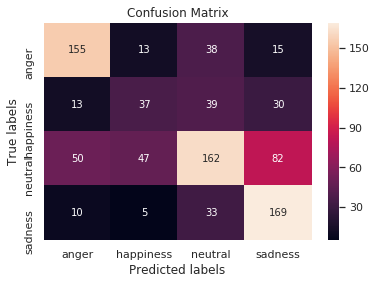


 Classification Report 
              precision    recall  f1-score   support

      anger       0.68      0.70      0.69       221
  happiness       0.36      0.31      0.33       119
    neutral       0.60      0.48      0.53       341
    sadness       0.57      0.78      0.66       217

avg / total       0.58      0.58      0.57       898
 

Train Epoch: 78 [0/3592 (0%)]	Loss: 0.915580

Train Epoch: 78 [2560/3592 (67%)]	Loss: 0.867332


Train set: Average loss: 0.0036


Train Accuracy: 2217/3592 (61%)


Test set: Average loss: 0.0046, Accuracy: 522/898 (58%)



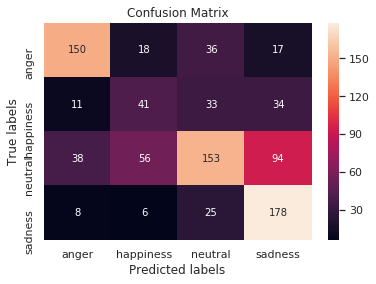


 Classification Report 
              precision    recall  f1-score   support

      anger       0.72      0.68      0.70       221
  happiness       0.34      0.34      0.34       119
    neutral       0.62      0.45      0.52       341
    sadness       0.55      0.82      0.66       217

avg / total       0.59      0.58      0.57       898
 

Train Epoch: 79 [0/3592 (0%)]	Loss: 0.854108

Train Epoch: 79 [2560/3592 (67%)]	Loss: 0.890248


Train set: Average loss: 0.0036


Train Accuracy: 2249/3592 (62%)


Test set: Average loss: 0.0047, Accuracy: 527/898 (58%)



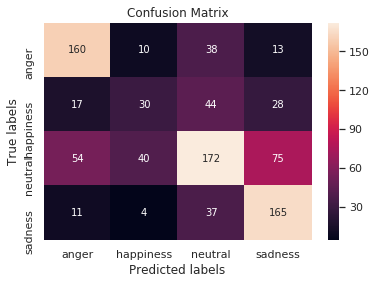


 Classification Report 
              precision    recall  f1-score   support

      anger       0.66      0.72      0.69       221
  happiness       0.36      0.25      0.30       119
    neutral       0.59      0.50      0.54       341
    sadness       0.59      0.76      0.66       217

avg / total       0.58      0.59      0.58       898
 

Train Epoch: 80 [0/3592 (0%)]	Loss: 0.825447

Train Epoch: 80 [2560/3592 (67%)]	Loss: 0.866594


Train set: Average loss: 0.0035


Train Accuracy: 2275/3592 (63%)


Test set: Average loss: 0.0046, Accuracy: 522/898 (58%)



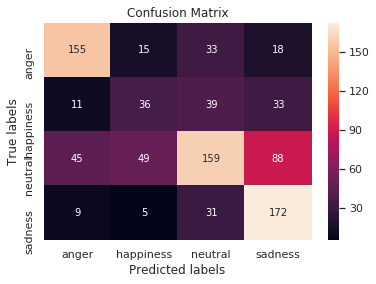


 Classification Report 
              precision    recall  f1-score   support

      anger       0.70      0.70      0.70       221
  happiness       0.34      0.30      0.32       119
    neutral       0.61      0.47      0.53       341
    sadness       0.55      0.79      0.65       217

avg / total       0.58      0.58      0.57       898
 



In [584]:
history = []
n_epoch = 81
for epoch in range(1, n_epoch):
    exp_lr_scheduler.step(epoch)
    
    train_loss, train_acc = train(epoch, lstm)
    
    test_loss, test_acc = test(lstm)
    
#     plateau_scheduler.step(test_loss)
    
    history.append([train_loss, train_acc, test_loss, test_acc])

In [585]:
history_df = pd.DataFrame(history, columns=["train_loss", "train_acc", "test_loss", "test_acc"])

In [586]:
history_df["epoch"] = [x for x in range(1, n_epoch)]

In [587]:
history_df

,train_loss,train_acc,test_loss,test_acc,epoch
0,0.005287,37,0.005894,43,1
1,0.004967,49,0.005320,44,2
2,0.004823,45,0.005208,49,3
3,0.004640,53,0.005019,51,4
4,0.004551,48,0.005011,56,5
5,0.004511,55,0.005086,51,6
6,0.004475,51,0.004987,51,7
7,0.004340,54,0.004871,53,8
8,0.004261,55,0.004956,50,9
9,0.004441,53,0.004824,52,10


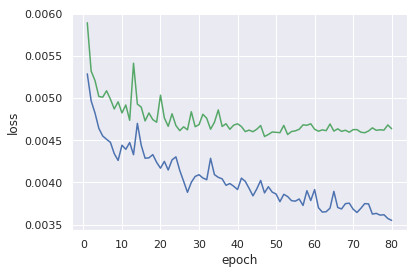

In [591]:
sns.set()
sns.lineplot(x='epoch', y='train_loss', data=history_df, color='b')
# plt.xticks(history_df.epoch)
sns.lineplot(x='epoch', y='test_loss', data=history_df, color='g')
plt.ylabel("loss")
plt.show()

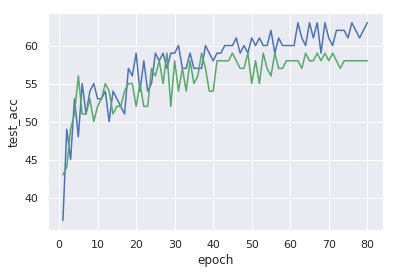

In [592]:
sns.set()
sns.lineplot(x='epoch', y='train_acc', data=history_df, color='b')
# plt.xticks(history_df.epoch)
sns.lineplot(x='epoch', y='test_acc', data=history_df, color='g')
plt.show()

In [590]:
torch.save(lstm, model_save_path + '/LSTM_2_layer_hidden_70_lr_rate_0.003.pth')